In [3]:
import urllib.request
import os
import zipfile
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import RMSprop
from shutil import copyfile

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!nvidia-smi

Fri Jul  2 01:48:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    33W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
!unzip -O cp949 '/content/drive/MyDrive/kfood.zip' -d '/content/6food'

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
         continuing with "central" filename version
  inflating: /content/6food/food/족발/Img_131_0673.jpg  
food/족발/Img_131_0674.jpg:  mismatching "local" filename (food/議깅컻/Img_131_0674.jpg),
         continuing with "central" filename version
  inflating: /content/6food/food/족발/Img_131_0674.jpg  
food/족발/Img_131_0675.jpg:  mismatching "local" filename (food/議깅컻/Img_131_0675.jpg),
         continuing with "central" filename version
  inflating: /content/6food/food/족발/Img_131_0675.jpg  
food/족발/Img_131_0676.jpg:  mismatching "local" filename (food/議깅컻/Img_131_0676.jpg),
         continuing with "central" filename version
 extracting: /content/6food/food/족발/Img_131_0676.jpg  
food/족발/Img_131_0677.jpg:  mismatching "local" filename (food/議깅컻/Img_131_0677.jpg),
         continuing with "central" filename version
  inflating: /content/6food/food/족발/Img_131_0677.jpg  
food/족발/Img_131_0678.jpg:  mismatching "local" filename (food/議깅컻/Img_131_0678.jpg),
    

In [7]:
food_list_kor=['갈비찜','김밥','김치볶음밥','김치전','김치찌개','깍두기','닭갈비','된장찌개','떡갈비','떡만두국','라면',
               '매운탕','물냉면','미역국','배추김치','불고기','삼겹살','삼계탕','설렁탕','송편','양념치킨','육개장','육회',
               '잡채','조개구이','족발','짜장면','파전','피자','후라이드치킨']  

try:
    os.mkdir('/content/foods')
    os.mkdir('/content/foods/training')
    os.mkdir('/content/foods/testing')


    for i in food_list_kor:
      os.mkdir('/content/foods/training/'+i)
      os.mkdir('/content/foods/testing/'+i)

except OSError:
    pass



In [8]:
import random
from shutil import copyfile
import time
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)

        else:
            print(filename + " is zero length, so ignoring.")
    print('성공')
    training_length = int(len(files) * SPLIT_SIZE)
    testing_length = int(len(files) - training_length)
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[0:training_length]
    testing_set = shuffled_set[training_length:]

    for filename in training_set:
        this_file = SOURCE + filename
        destination = TRAINING + filename
        copyfile(this_file, destination)


    for filename in testing_set:
        this_file = SOURCE + filename
        destination = TESTING + filename
        copyfile(this_file, destination)
  

In [9]:
SOURCE_LIST=[]
for i in food_list_kor:
  SOURCE_LIST.append('/content/6food/food/'+i+'/')

TRAINING_LIST=[]
for i in food_list_kor:
  TRAINING_LIST.append('/content/foods/training/'+i+'/')

TESTING_LIST=[]
for i in food_list_kor:
  TESTING_LIST.append('/content/foods/testing/'+i+'/')

In [10]:
split_size = .9


for i in range(29):
  split_data(SOURCE_LIST[i], TRAINING_LIST[i], TESTING_LIST[i], split_size)

성공
성공
성공
성공
성공
성공
성공
성공
성공
성공
org_url.csv is zero length, so ignoring.
성공
성공
성공
성공
성공
성공
성공
성공
성공
org_url.csv is zero length, so ignoring.
성공
org_url.csv is zero length, so ignoring.
성공
성공
org_url.csv is zero length, so ignoring.
성공
org_url.csv is zero length, so ignoring.
성공
org_url.csv is zero length, so ignoring.
성공
성공
org_url.csv is zero length, so ignoring.
성공
성공
org_url.csv is zero length, so ignoring.
성공


In [11]:
print("Number of training cat images", len(os.listdir('/content/foods/training/갈비찜/')))
print("Number of testing cat images", len(os.listdir('/content/foods/testing/갈비찜/')))

Number of training cat images 901
Number of testing cat images 101


In [12]:
TRAINING_DIR = "/content/foods/training/"

train_datagen = ImageDataGenerator(rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                    batch_size=256,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))

VALIDATION_DIR = "/content/foods/testing"

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                              batch_size=256,
                                                              class_mode='categorical',
                                                              target_size=(224, 224))

Found 26068 images belonging to 30 classes.
Found 2917 images belonging to 30 classes.


In [13]:
# Fixed for our Cats & Dogs classes
NUM_CLASSES = 30

# Fixed for Cats & Dogs color images
CHANNELS = 3

IMAGE_RESIZE = 224
RESNET50_POOLING_AVERAGE = 'avg'
DENSE_LAYER_ACTIVATION = 'softmax'
OBJECTIVE_FUNCTION = 'categorical_crossentropy'

# Common accuracy metric for all outputs, but can use different metrics for different output
LOSS_METRICS = ['accuracy']

# EARLY_STOP_PATIENCE must be < NUM_EPOCHS
NUM_EPOCHS = 50
EARLY_STOP_PATIENCE = 3

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# Training images processed in each step would be no.-of-train-images / STEPS_PER_EPOCH_TRAINING
STEPS_PER_EPOCH_TRAINING = 10
STEPS_PER_EPOCH_VALIDATION = 10

# These steps value should be proper FACTOR of no.-of-images in train & valid folders respectively
# NOTE that these BATCH* are for Keras ImageDataGenerator batching to fill epoch step input
BATCH_SIZE_TRAINING = 100
BATCH_SIZE_VALIDATION = 100

# Using 1 to easily manage mapping between test_generator & prediction for submission preparation
BATCH_SIZE_TESTING = 1

In [74]:
#Still not talking about our train/test data or any pre-processing.
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
model = Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(input_shape=(224, 224, 3),include_top = False, pooling = RESNET50_POOLING_AVERAGE, weights = 'imagenet'))

# 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
model.add(Dense(NUM_CLASSES, activation = DENSE_LAYER_ACTIVATION))

# Say not to train first layer (ResNet) model as it is already trained
model.layers[0].trainable = False

In [75]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3)


# if not os.path.exists(model_dir):
#     os.mkdir(model_dir)

model_path = '/content/drive/MyDrive/inception_model_v4'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense_2 (Dense)              (None, 30)                61470     
Total params: 23,649,182
Trainable params: 61,470
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
from tensorflow.keras import optimizers

sgd = optimizers.SGD(lr = 0.01, decay = 1e-6, momentum = 0.9, nesterov = True)
model.compile(optimizer = sgd, loss = OBJECTIVE_FUNCTION, metrics = LOSS_METRICS)



# model을 train하기 (epoch를 수정하며 성능 높이기)
history = model.fit_generator(
            train_generator,
            validation_data=validation_generator,
            epochs=50,
            verbose=1,
            batch_size=256,
            callbacks = [checkpoint,early_stopping])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/50
  2/102 [..............................] - ETA: 39s - loss: 3.6696 - accuracy: 0.0176  

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 98/102 [===========================>..] - ETA: 17s - loss: 3.3698 - accuracy: 0.0474

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 486s 5s/step - loss: 3.3685 - accuracy: 0.0476 - val_loss: 3.2992 - val_accuracy: 0.0720

Epoch 00001: val_loss improved from inf to 3.29917, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 2/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 60/102 [================>.............] - ETA: 2:54 - loss: 3.3107 - accuracy: 0.0596

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 453s 4s/step - loss: 3.3038 - accuracy: 0.0615 - val_loss: 3.2746 - val_accuracy: 0.0655

Epoch 00002: val_loss improved from 3.29917 to 3.27459, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 3/50
  2/102 [..............................] - ETA: 7:10 - loss: 3.2926 - accuracy: 0.0527

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 36/102 [=========>....................] - ETA: 4:46 - loss: 3.2808 - accuracy: 0.0652

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 451s 4s/step - loss: 3.2790 - accuracy: 0.0667 - val_loss: 3.2388 - val_accuracy: 0.0754

Epoch 00003: val_loss improved from 3.27459 to 3.23880, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 4/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 62/102 [=================>............] - ETA: 2:44 - loss: 3.2646 - accuracy: 0.0718

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 444s 4s/step - loss: 3.2588 - accuracy: 0.0720 - val_loss: 3.2398 - val_accuracy: 0.0867

Epoch 00004: val_loss did not improve from 3.23880
Epoch 5/50
102/102 [==============================] - 444s 4s/step - loss: 3.2471 - accuracy: 0.0766 - val_loss: 3.2143 - val_accuracy: 0.0939

Epoch 00005: val_loss improved from 3.23880 to 3.21430, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 6/50
  1/102 [..............................] - ETA: 6:51 - loss: 3.2724 - accuracy: 0.0664

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 88/102 [========================>.....] - ETA: 59s - loss: 3.2391 - accuracy: 0.0798 

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 457s 4s/step - loss: 3.2372 - accuracy: 0.0806 - val_loss: 3.1932 - val_accuracy: 0.0843

Epoch 00006: val_loss improved from 3.21430 to 3.19324, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 7/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 12/102 [==>...........................] - ETA: 6:26 - loss: 3.2239 - accuracy: 0.0869

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 455s 4s/step - loss: 3.2237 - accuracy: 0.0820 - val_loss: 3.1889 - val_accuracy: 0.0977

Epoch 00007: val_loss improved from 3.19324 to 3.18891, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 8/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 98/102 [===========================>..] - ETA: 16s - loss: 3.2206 - accuracy: 0.0851

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 450s 4s/step - loss: 3.2198 - accuracy: 0.0849 - val_loss: 3.1650 - val_accuracy: 0.1028

Epoch 00008: val_loss improved from 3.18891 to 3.16501, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 9/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 87/102 [========================>.....] - ETA: 1:02 - loss: 3.2093 - accuracy: 0.0875

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 442s 4s/step - loss: 3.2074 - accuracy: 0.0875 - val_loss: 3.1574 - val_accuracy: 0.1183

Epoch 00009: val_loss improved from 3.16501 to 3.15735, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 10/50
  5/102 [>.............................] - ETA: 6:42 - loss: 3.2141 - accuracy: 0.0898

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


  6/102 [>.............................] - ETA: 6:37 - loss: 3.2180 - accuracy: 0.0924

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 434s 4s/step - loss: 3.2013 - accuracy: 0.0890 - val_loss: 3.1605 - val_accuracy: 0.1039

Epoch 00010: val_loss did not improve from 3.15735
Epoch 11/50
102/102 [==============================] - 440s 4s/step - loss: 3.1935 - accuracy: 0.0920 - val_loss: 3.1253 - val_accuracy: 0.1186

Epoch 00011: val_loss improved from 3.15735 to 3.12527, saving model to /content/drive/MyDrive/inception_model_v4


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/inception_model_v4/assets
Epoch 12/50


/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 17/102 [====>.........................] - ETA: 5:52 - loss: 3.1795 - accuracy: 0.1025

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))


102/102 [==============================] - 446s 4s/step - loss: 3.1863 - accuracy: 0.0958 - val_loss: 3.1486 - val_accuracy: 0.0994

Epoch 00012: val_loss did not improve from 3.12527
Epoch 13/50
102/102 [==============================] - 445s 4s/step - loss: 3.1822 - accuracy: 0.0971 - val_loss: 3.1393 - val_accuracy: 0.1111

Epoch 00013: val_loss did not improve from 3.12527
Epoch 14/50
102/102 [==============================] - 447s 4s/step - loss: 3.1747 - accuracy: 0.0954 - val_loss: 3.1286 - val_accuracy: 0.1334

Epoch 00014: val_loss did not improve from 3.12527


<Figure size 432x288 with 0 Axes>

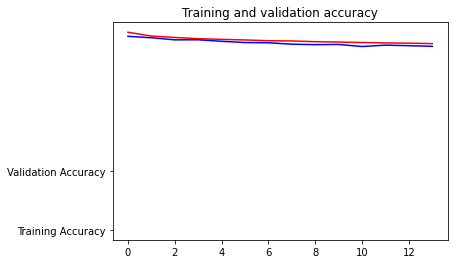

<Figure size 432x288 with 0 Axes>

In [65]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#training과 test data에 result를 추출하기
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # epochs 수 확인

#각 epoch마다 training과 validation accuracy 확인
plt.plot(epochs, loss, 'r', "Training Accuracy")
plt.plot(epochs, val_loss, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

In [99]:
# food_list_kor=['갈비찜','김밥','김치볶음밥','김치전','김치찌개','깍두기','닭갈비','된장찌개','떡갈비','떡만두국','라면',
#              '매운탕','물냉면','미역국','배추김치','불고기','삼겹살','삼계탕','설렁탕','송편','양념치킨','육개장','육회',
 #              '잡채','조개구이','족발','짜장면','파전','피자','후라이드치킨']  

import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt


uploaded = files.upload()

for fn in uploaded.keys():
 
  # image 예측하기
  path = '/content/' + fn
  img = image.load_img(path, target_size=(224, 224))
  x = image.img_to_array(img)
  
  x = np.expand_dims(x, axis=0)

  image_tensor = np.vstack([x])
  classes = model.predict(image_tensor)
  print(classes)
  classes = np.argmax(classes)

  print(classes)

  if classes==0:
    print(fn + " 갈비찜")
  elif classes==1:
    print(fn + " 김밥")
  elif classes==2:
    print(fn + " 김치볶음밥")
  elif classes==3:
    print(fn + " 김치전")
  elif classes==4:
    print(fn + " 삼겹살")  
  elif classes==5:
    print(fn + " 깍두기")
  elif classes==6:
    print(fn + " 닭갈비")
  elif classes==7:
    print(fn + " 후라이드치킨")
  elif classes==8:
    print(fn + " 떡갈비")
  elif classes==9:
    print(fn + " 떡만두국")
  elif classes==10:
    print(fn + " 라면")
  elif classes==11:
    print(fn + " 매운탕")
  elif classes==12:
    print(fn + " 물냉면")
  elif classes==13:
    print(fn + " 된장찌개")
  elif classes==14:
    print(fn + " 배추김치")
  elif classes==15:
    print(fn + " 불고기")
  elif classes==16:
    print(fn + " 김치찌개")
  elif classes==17:
    print(fn + " 미역국")
  elif classes==18:
    print(fn + " 설렁탕")
  elif classes==19:
    print(fn + " 송편")
  elif classes==20:
    print(fn + " 양념치킨")
  elif classes==21:
    print(fn + " 육개장")
  elif classes==22:
    print(fn + " 육회")
  elif classes==23:
    print(fn + " 잡채")
  elif classes==24:
    print(fn + " 조개구이")
  elif classes==25:
    print(fn + " 족발")
  elif classes==26:
    print(fn + " 짜장면")
  elif classes==27:
    print(fn + " 파전")
  elif classes==28:
    print(fn + " 피자")
  else:
    print(fn + " 삼계탕")

import pandas as pd
df = pd.read_csv('/content/drive/MyDrive/nutrition3.csv')

print(df.iloc[classes])

Saving 후라이드.jfif to 후라이드 (4).jfif
[[0.00222634 0.03900517 0.01564461 0.01352002 0.13506633 0.01744918
  0.00180631 0.2189471  0.00191274 0.002175   0.01053646 0.00385835
  0.01501756 0.02654386 0.0012485  0.00289122 0.01033012 0.02127174
  0.21517883 0.02917051 0.00823967 0.00551444 0.0029482  0.01988737
  0.00566158 0.01254571 0.00122136 0.0057062  0.06321446 0.091261  ]]
7
후라이드.jfif 후라이드치킨
index              후라이드치킨
kcal                  347
carbohydrate(g)        14
protein(g)             21
fat(g)                 23
Name: 7, dtype: object


In [ ]:
# 갈비찜 1 인분당 - 칼로리: 597kcal | 지방: 43.59g | 탄수화물: 15.44g | 단백질: 34.53g
# 김밥 1줄당 - 칼로리: 485kcal | 지방: 15.30g | 탄수화물: 73.50g | 단백질: 12.20g 
# 김치볶음밥 1 인분당 - 칼로리: 446kcal | 지방: 12.37g | 탄수화물: 75.09g | 단백질: 8.75g
# 김치전 1 소접시당 - 칼로리: 153kcal | 지방: 6.71g | 탄수화물: 17.22g | 단백질: 6.32g
# 김치찌개 1 인분당 - 칼로리: 121kcal | 지방: 7.57g | 탄수화물: 6.47g | 단백질: 7.51g
# 깍두기 1 소접시당 - 칼로리: 16kcal | 지방: 0.29g | 탄수화물: 3.21g | 단백질: 0.62g
# 닭갈비 1 인분당 - 칼로리: 585kcal | 지방: 26.98g | 탄수화물: 43.18g | 단백질: 40.20g
# 된장찌개 1 인분당 - 칼로리: 171kcal | 지방: 5.60g | 탄수화물: 16.77g | 단백질: 15.01g
# 떡갈비 1 인분당 - 칼로리: 416kcal | 지방: 29.19g | 탄수화물: 4.05g | 단백질: 32.98g
# 떡만두국 1 인분당 - 칼로리: 442kcal | 지방: 11.05g | 탄수화물: 68.42g | 단백질: 15.00g
# 라면 1 봉지당 - 칼로리: 385kcal | 지방: 14.54g | 탄수화물: 55.68g | 단백질: 7.90g
# 매운탕 1 인분당 - 칼로리: 213kcal | 지방: 5.31g | 탄수화물: 6.24g | 단백질: 34.10g
# 물냉면 1 인분당 - 칼로리: 383kcal | 지방: 5.74g | 탄수화물: 64.58g | 단백질: 16.50g
# 미역국 1 인분당 - 칼로리: 290kcal | 지방: 16.27g | 탄수화물: 12.39g | 단백질: 25.12g
# 배추김치 1 인분당 - 칼로리: 8kcal | 지방: 0.12g | 탄수화물: 1.58g | 단백질: 0.66g
# 불고기 1 인분당 - 칼로리: 486kcal | 지방: 23.86g | 탄수화물: 14.77g | 단백질: 48.38g
# 삼겹살 1 인분당 - 칼로리: 661kcal | 지방: 56.43g | 탄수화물: 1.18g | 단백질: 34.47g
# 삼계탕 1 인분당 - 칼로리: 454kcal | 지방: 15.89g | 탄수화물: 20.41g | 단백질: 55.50g
# 설렁탕 1 인분당 - 칼로리: 424kcal | 지방: 12.93g | 탄수화물: 42.70g | 단백질: 32.67g
# 송편 10 개당 - 칼로리: 460kcal | 지방: 3g | 탄수화물: 90.81g | 단백질: 9.1g
# 양념치킨 1인분당 - 칼로리: 443kcal | 지방: 6.00g | 탄수화물: 19.00g | 단백질: 26.00g 
# 육개장 1 인분당 - 칼로리: 165kcal | 지방: 7.57g | 탄수화물: 10.45g | 단백질: 14.32g
# 육회 1 접시당 - 칼로리: 101kcal | 지방: 4.38g | 탄수화물: 2.13g | 단백질: 12.56g
# 잡채 1 인분당 - 칼로리: 285kcal | 지방: 10.16g | 탄수화물: 43.23g | 단백질: 7.59g
# 조개구이 1인분당 - 칼로리: 138kcal | 지방: 6.86g | 탄수화물: 3.15g | 단백질: 14.95g
# 족발 1 인분당 - 칼로리: 458kcal | 지방: 31.42g | 탄수화물: 0.64g | 단백질: 43.06g
# 짜장면 1 인분당 - 칼로리: 785kcal | 지방: 19.98g | 탄수화물: 129.41g | 단백질: 26.81g
# 파전 1 소접시당 - 칼로리: 176kcal | 지방: 7.29g | 탄수화물: 21.82g | 단백질: 6.69g
# 피자 1 조각당 - 칼로리: 255kcal | 지방: 11.26g | 탄수화물: 28.58g | 단백질: 9.43g
# 후라이드치킨 1인분당 - 칼로리: 347kcal | 지방: 23.00g | 탄수화물: 14.00g | 단백질: 21.00g 

In [50]:
df

,index,kcal,carbohydrate(g),protein(g),fat(g)
0,갈비찜,597,15.00,34.00,43.00
1,김밥,485,73.00,12.00,15.00
2,김치볶음밥,446,75.00,8.00,12.00
3,김치전,153,17.00,6.00,6.00
4,김치찌개,121,6.00,7.00,7.00
5,깍두기,16,3.00,0.62,0.29
6,닭갈비,585,43.00,40.00,26.00
7,된장찌개,171,16.00,15.00,5.00
8,떡갈비,416,4.00,32.00,29.00
9,떡만두국,442,68.00,15.00,11.00


In [53]:
df.iloc[0]

index              갈비찜
kcal               597
carbohydrate(g)     15
protein(g)          34
fat(g)              43
Name: 0, dtype: object